###### Forecst Store Sales using a Kaggle Dataset
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

# Import Libraries and load the data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_squared_error

In [2]:
# load all the data files into dataframes

df_train = pd.read_csv('data/train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_test = pd.read_csv('data/test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_holidays = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True)
df_oil = pd.read_csv('data/oil.csv',  parse_dates = ['date'], infer_datetime_format = True)
df_sample_submission = pd.read_csv('data/sample_submission.csv',index_col='id')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/train.csv',  parse_dates = ['date'], infer_datetime_format = True)

## Profile holidays data frame

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [3]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [4]:
df_holidays.sample(25)

,date,type,locale,locale_name,description,transferred
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
207,2015-12-24,Additional,National,Ecuador,Navidad-1,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False
230,2016-04-26,Event,National,Ecuador,Terremoto Manabi+10,False
240,2016-05-05,Event,National,Ecuador,Terremoto Manabi+19,False
249,2016-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
167,2015-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
315,2017-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
92,2014-01-01,Holiday,National,Ecuador,Primer dia del ano,False
291,2016-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False


## Profile Stores dataframe
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores

In [5]:
df_stores.sample(25)

,store_nbr,city,state,type,cluster
46,47,Quito,Pichincha,A,14
34,35,Playas,Guayas,C,3
42,43,Esmeraldas,Esmeraldas,E,10
28,29,Guayaquil,Guayas,E,10
12,13,Latacunga,Cotopaxi,C,15
43,44,Quito,Pichincha,A,5
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
50,51,Guayaquil,Guayas,A,17
48,49,Quito,Pichincha,A,11
3,4,Quito,Pichincha,D,9


Text(0.5, 1.0, 'Number of Stores by Type and Cluster')

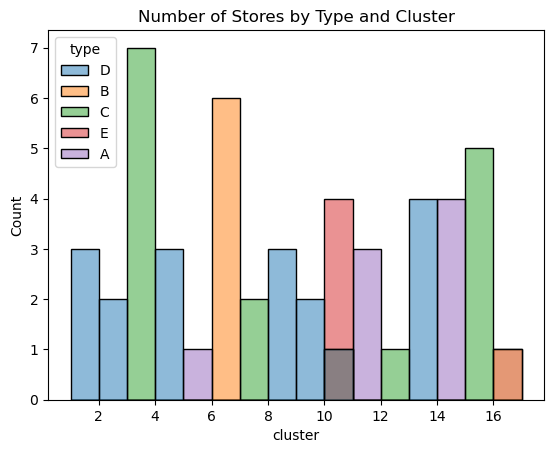

In [6]:
sns.histplot(data = df_stores
            , x='cluster'
            , hue='type'
            ,binwidth = 1).set_title('Number of Stores by Type and Cluster')

## Profile the oil datframe
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [7]:
df_oil.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
df_oil.tail(20)

,date,dcoilwtico
1198,2017-08-04,49.57
1199,2017-08-07,49.37
1200,2017-08-08,49.07
1201,2017-08-09,49.59
1202,2017-08-10,48.54
1203,2017-08-11,48.81
1204,2017-08-14,47.59
1205,2017-08-15,47.57
1206,2017-08-16,46.80
1207,2017-08-17,47.07


In [9]:
# find null values
df_oil[df_oil['dcoilwtico'].isnull()].count()

date          43
dcoilwtico     0
dtype: int64

Text(0.5, 1.0, 'Trend of Oil Prices')

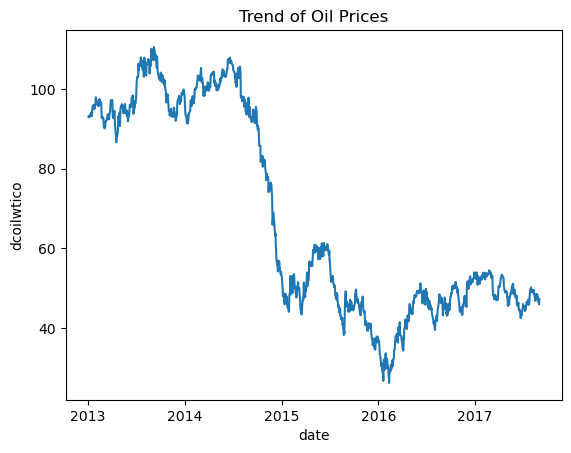

In [10]:
sns.lineplot(data=df_oil,  x='date', y='dcoilwtico').set_title('Trend of Oil Prices')

### Feature engineering on the oil dataset by filling missing values

In [11]:
# initialize the data with the first value
df_oil.at[0,'dcoilwtico']= 93.14

#for missing values take the average of the previous and the following value
df_oil.dcoilwtico = df_oil.dcoilwtico.fillna((df_oil.dcoilwtico.shift() + df_oil.dcoilwtico.shift(-1))/2)

In [12]:
df_oil[df_oil['dcoilwtico'].isnull()]

,date,dcoilwtico
1174,2017-07-03,NaN
1175,2017-07-04,NaN


In [13]:
# fill the last 2 missing values

df_oil.at[1174,'dcoilwtico'] = (df_oil.at[1173,'dcoilwtico'] + df_oil.at[1176,'dcoilwtico'])/2
df_oil.at[1175,'dcoilwtico'] = (df_oil.at[1173,'dcoilwtico'] + df_oil.at[1176,'dcoilwtico'])/2

# Profile the transactions dataset

In [14]:
df_transactions.head(15)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [15]:
df_transactions.tail(5)

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [16]:
df_transactions.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [17]:
df_transactions.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [18]:
#sns.lineplot(data=df_transactions
#             ,  x='date'
#             , y='sales'
#            ,hue='store_nbr').set_title('Trend of Sales by Store')

In [19]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [20]:
df_train.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


## Train the Prophet model for a single store and family to build framework

In [21]:
#creaate a copy and check the data types
df_train_p = pd.DataFrame()
df_train_p = df_train.query("store_nbr == 9 and family == 'PREPARED FOODS' ").copy(deep=True)
df_train_p.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [22]:
#rename the columns
df_train_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)

In [23]:
df_train_p.head()

,ds,store_nbr,family,y,onpromotion
id,,,,,
1778,2013-01-01,9,PREPARED FOODS,0.0,0
3560,2013-01-02,9,PREPARED FOODS,83.0,0
5342,2013-01-03,9,PREPARED FOODS,66.0,0
7124,2013-01-04,9,PREPARED FOODS,57.0,0
8906,2013-01-05,9,PREPARED FOODS,84.0,0


In [27]:
#train the model
model = Prophet()
model.fit(df_train_p)
model

10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
#make predictions
future = model.make_future_dataframe(periods=15)
preds = model.predict(future)
preds.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1694,2017-08-26,129.886121,122.317650,179.047410,129.886121,129.886121,20.153880,20.153880,20.153880,24.164108,24.164108,24.164108,-4.010229,-4.010229,-4.010229,0.0,0.0,0.0,150.040000
1695,2017-08-27,129.942435,131.012336,187.324375,129.942435,129.942435,28.359533,28.359533,28.359533,32.395447,32.395447,32.395447,-4.035915,-4.035915,-4.035915,0.0,0.0,0.0,158.301967
1696,2017-08-28,129.998749,91.289022,147.017976,129.998673,129.998749,-12.107936,-12.107936,-12.107936,-8.074672,-8.074672,-8.074672,-4.033264,-4.033264,-4.033264,0.0,0.0,0.0,117.890813
1697,2017-08-29,130.055063,88.614928,145.602363,130.054626,130.055063,-12.913229,-12.913229,-12.913229,-8.920545,-8.920545,-8.920545,-3.992684,-3.992684,-3.992684,0.0,0.0,0.0,117.141834
1698,2017-08-30,130.111377,83.677763,141.212691,130.109887,130.111377,-16.972732,-16.972732,-16.972732,-13.067315,-13.067315,-13.067315,-3.905417,-3.905417,-3.905417,0.0,0.0,0.0,113.138645


In [50]:
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)

,ds,y,yhat
1679,2017-08-11,112.10000,106.516865
1680,2017-08-12,129.90399,147.563051
1681,2017-08-13,105.16900,156.267224
1682,2017-08-14,114.12000,116.220117
1683,2017-08-15,154.55300,115.744079
1684,2017-08-16,NaN,111.912261
1685,2017-08-17,NaN,115.106941
1686,2017-08-18,NaN,109.082148
1687,2017-08-19,NaN,149.767565
1688,2017-08-20,NaN,158.110919


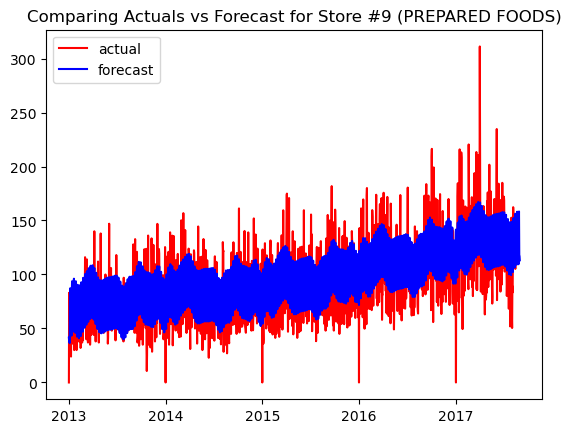

In [48]:
plt.plot(final_df['ds'] , final_df['y'], color='red' , label='actual')
plt.plot(final_df['ds'] , final_df['yhat'], color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for Store #9 (PREPARED FOODS)')
plt.legend()

In [58]:
train_preds = final_df.query("ds<='2017-08-15'")
msle = mean_squared_log_error(train_preds[['y']] , train_preds[['yhat']])
mse = mean_squared_error(train_preds[['y']] , train_preds[['yhat']])


print("MSLE is ", msle)                                          

MSLE is  0.11490401042193067
MSE is  479.9478413957856
